In [59]:
# Dependencies
import os
import sys
import pathlib
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hvplot.pandas
import scipy.stats as st
from uszipcode import SearchEngine


# Import the API key
from config import geoapify_key
from config import census_key

DATA CLEANUP

The first set of data was obtained from the OpenBreweryAPI. The API is free, however it limits the number of queries to 200 rows and restricts sourcing of data to 2 pages at a time. To load all necessary data, it was necessary to create a loop to move through all 156 pages of the API and collect 100 cases per page or 200 every two pages for the United_States location. Through out the document, our team used multiple APIs with large number of rows, and so for the ease of use each dataframe used later was also as saved a csv allowing easy data retrieval for each block of code.   

In [2]:
# URL for GET requests to retrieve brewery data
base_url = 'https://api.openbrewerydb.org/v1/breweries?by_country=United_States'

# Define an empty list to fetch the page data for each set of data
brewery_data = []

# Loop through the pages to get all the data
for page in range(1, 156):
    query_url = base_url + "&page="+ str(page) + "&per_page=200"
    response = requests.get(query_url).json()
    brewery_data.append(response)

# Create a list of all the breweries
breweries = []
for page in brewery_data:
    for brewery in page:
        breweries.append(brewery)

# Create a dataframe from the list of breweries
breweries_df = pd.DataFrame(breweries)

breweries_df.head()

,id,name,brewery_type,address_1,address_2,address_3,city,state_province,postal_code,country,longitude,latitude,phone,website_url,state,street
0,5128df48-79fc-4f0f-8b52-d06be54d0cec,(405) Brewing Co,micro,1716 Topeka St,None,None,Norman,Oklahoma,73069-8224,United States,-97.46818222,35.25738891,4058160490,http://www.405brewing.com,Oklahoma,1716 Topeka St
1,9c5a66c8-cc13-416f-a5d9-0a769c87d318,(512) Brewing Co,micro,407 Radam Ln Ste F200,None,None,Austin,Texas,78745-1197,United States,None,None,5129211545,http://www.512brewing.com,Texas,407 Radam Ln Ste F200
2,ef970757-fe42-416f-931d-722451f1f59c,10 Barrel Brewing Co,large,1501 E St,None,None,San Diego,California,92101-6618,United States,-117.129593,32.714813,6195782311,http://10barrel.com,California,1501 E St
3,6d14b220-8926-4521-8d19-b98a2d6ec3db,10 Barrel Brewing Co,large,62970 18th St,None,None,Bend,Oregon,97701-9847,United States,-121.281706,44.08683531,5415851007,http://www.10barrel.com,Oregon,62970 18th St
4,e2e78bd8-80ff-4a61-a65c-3bfbd9d76ce2,10 Barrel Brewing Co,large,1135 NW Galveston Ave Ste B,None,None,Bend,Oregon,97703-2465,United States,-121.3288021,44.0575649,5415851007,None,Oregon,1135 NW Galveston Ave Ste B


The describe function below shows that 2,392 rows are misisng the longitude and latitude. Since the number of rows consitutde 30% of the full data set, 
it was important to backfill the missing information.   

In [3]:
#creates a summary table of the data
breweries_df.describe()

,id,name,brewery_type,address_1,address_2,address_3,city,state_province,postal_code,country,longitude,latitude,phone,website_url,state,street
count,7936,7936,7936,7153,4,0,7936,7936,7936,7936,5544,5544,7141,6787,7936,7153
unique,7936,7791,10,7064,4,0,2908,54,7695,2,5433,5433,6950,6437,54,7064
top,5128df48-79fc-4f0f-8b52-d06be54d0cec,Granite City Food & Brewery,micro,303 Main St,Estacada,NaN,Portland,California,64108,United States,-112.0773456,33.4485866,5122442739,http://www.gcfb.net,California,303 Main St
freq,1,6,4115,3,1,NaN,105,912,5,7935,6,6,5,23,912,3


In [4]:
#Prepare the breweries Database for analysis 
#drop brevery id, address_2, address_3, country, phone, website_url, and street
clean_breweries_df = breweries_df.drop(columns=['id', 'address_2', 'address_3', 'country', 'phone', 'website_url', 'street'])
clean_breweries_df.head()

,name,brewery_type,address_1,city,state_province,postal_code,longitude,latitude,state
0,(405) Brewing Co,micro,1716 Topeka St,Norman,Oklahoma,73069-8224,-97.46818222,35.25738891,Oklahoma
1,(512) Brewing Co,micro,407 Radam Ln Ste F200,Austin,Texas,78745-1197,None,None,Texas
2,10 Barrel Brewing Co,large,1501 E St,San Diego,California,92101-6618,-117.129593,32.714813,California
3,10 Barrel Brewing Co,large,62970 18th St,Bend,Oregon,97701-9847,-121.281706,44.08683531,Oregon
4,10 Barrel Brewing Co,large,1135 NW Galveston Ave Ste B,Bend,Oregon,97703-2465,-121.3288021,44.0575649,Oregon


Here's further confirmation that the necessary longtidue and latitude info is misisng in large numbers.   

In [5]:
#count missing values for each column
clean_breweries_df.isnull()
#count missing values for each column 
clean_breweries_df.isnull().sum()

name                 0
brewery_type         0
address_1          783
city                 0
state_province       0
postal_code          0
longitude         2392
latitude          2392
state                0
dtype: int64

We decided to use Geopify to pull latitude and longtiude for the missing zip codes. Since Geopify did not recognize the postal code +4 format; 
opted to use the uszipcode package to extract the first 5 digits. While long/lat can also be pulled via uszipcode package, the exercise is meant to demonstrate the use of API for sourcing additional information.  

In [6]:
#create a new column in dataframe with first 5 digits of zip code ensuring the information is stored as stings & recognized as zipcodes.
search = SearchEngine()

def extract_zipcode(zipcode):
    # Remove +4 extension if present
    zipcode = zipcode.split('-')[0]
    zipcode_obj = search.by_zipcode(zipcode)
    if zipcode_obj is not None:
        return str(zipcode_obj.zipcode)[:5].zfill(5)
    else:
        return None

clean_breweries_df['zip_code'] = clean_breweries_df['postal_code'].apply(extract_zipcode).astype(str)

#add a ditinct ID number to each row 
clean_breweries_df['brewery_id'] = clean_breweries_df.index + 1
clean_breweries_df.head()

,name,brewery_type,address_1,city,state_province,postal_code,longitude,latitude,state,zip_code,brewery_id
0,(405) Brewing Co,micro,1716 Topeka St,Norman,Oklahoma,73069-8224,-97.46818222,35.25738891,Oklahoma,73069,1
1,(512) Brewing Co,micro,407 Radam Ln Ste F200,Austin,Texas,78745-1197,None,None,Texas,78745,2
2,10 Barrel Brewing Co,large,1501 E St,San Diego,California,92101-6618,-117.129593,32.714813,California,92101,3
3,10 Barrel Brewing Co,large,62970 18th St,Bend,Oregon,97701-9847,-121.281706,44.08683531,Oregon,97701,4
4,10 Barrel Brewing Co,large,1135 NW Galveston Ave Ste B,Bend,Oregon,97703-2465,-121.3288021,44.0575649,Oregon,97703,5


In [7]:
#load dataframe into csv
clean_breweries_df.to_csv('csv building blocks/breweries.csv', index=False)
#show count by the length of the postal code to see if there are any invalid postal codes
clean_breweries_df['zip_code'].str.len().value_counts()

5    7929
4       7
Name: zip_code, dtype: int64

In [8]:
#use dataframe from the csv breweries.csv
input_path = os.path.join("csv building blocks/breweries.csv")
csv_breweries_df = pd.read_csv(input_path)

Creating a dataframe with missing information to temporarily separate from the clean data for ease of use.

In [10]:
#extract rows with missing longitude and create a new dataframe - all longitude missing values correspond to missinging latitude values
missing_long_df = csv_breweries_df[csv_breweries_df['longitude'].isnull()]

#create a new dataframe with only the missing longitude rowsbased on clean_breweries_df
missing_long_df = clean_breweries_df[clean_breweries_df['longitude'].isnull()]

missing_long_df.head()

,name,brewery_type,address_1,city,state_province,postal_code,longitude,latitude,state,zip_code,brewery_id
1,(512) Brewing Co,micro,407 Radam Ln Ste F200,Austin,Texas,78745-1197,None,None,Texas,78745,2
18,12 Gates Brewing Company,brewpub,80 Earhart Dr Ste 20,Williamsville,New York,14221-7804,None,None,New York,14221,19
19,12 West Brewing Company,micro,3000 E Ray Rd Bldg 6,Gilbert,Arizona,85296-7832,None,None,Arizona,85296,20
24,12welve Eyes Brewing,micro,141 E 4th St Ste LL2,Saint Paul,Minnesota,55101-1639,None,None,Minnesota,55101,25
26,13 Stripes Brewery,brewpub,"250 Mill St, Suite PW3101",Taylors,South Carolina,29687,None,None,South Carolina,29687,27


In [11]:
#drop the missing_long dataframe into a csv file
missing_long_df.to_csv('csv building blocks/breweries_missing_values.csv', index=False)

In [12]:
#use dataframe from the csv_breweries_missing_values.csv
input_path2 = os.path.join("csv building blocks/breweries_missing_values.csv")
csv_breweries_missing_df = pd.read_csv(input_path2)

Finally demonstrate use of Geopify for obtianing missing information - encountered errors were bypassed with the try/except. The code runs for approximately 10 mins over 2.3K rows  - can be skipped since all necessary data has already been saved in a csv below.  

In [13]:
#for missing longitude, use geopify to look up the longitude and latitude
for index, row in csv_breweries_missing_df.iterrows():
    postcode = row['zip_code']
    target_url = f"https://api.geoapify.com/v1/geocode/autocomplete?text={postcode}&limit=1&type=postcode&format=json&apiKey={geoapify_key}"
    response = requests.get(target_url)

    try:
        json_response = json.loads(response.text)
        if json_response:
            csv_breweries_missing_df.loc[index, 'longitude'] = json_response['results'][0]['lon']
            csv_breweries_missing_df.loc[index, 'latitude'] = json_response['results'][0]['lat']
            print(f"index: {index}, postcode: {postcode}, longitude: {json_response['results'][0]['lon']}, latitude: {json_response['results'][0]['lat']}") 

        else:
            print(f"Error: Empty JSON response for index {index}, postcode {postcode}")
    except IndexError:
        print(f"Error: IndexError occurred for index {index}, postcode {postcode}")
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON response for index {index}, postcode {postcode}")

csv_breweries_missing_df.head()

index: 0, postcode: 78745, longitude: -97.792614846, latitude: 30.208605656
index: 1, postcode: 14221, longitude: -78.729920877, latitude: 42.980952841
index: 2, postcode: 85296, longitude: -111.762518433, latitude: 33.335136701
index: 3, postcode: 55101, longitude: -93.088300242, latitude: 44.955919207
index: 4, postcode: 29687, longitude: -82.327800669, latitude: 34.991467109
index: 5, postcode: 27603, longitude: -78.66089377, latitude: 35.71301003
index: 6, postcode: 56442, longitude: -94.116315338, latitude: 46.677860236
index: 7, postcode: 05478, longitude: -73.104390267, latitude: 44.803484605
index: 8, postcode: 21157, longitude: -76.983937143, latitude: 39.558197671
index: 9, postcode: 22553, longitude: -77.60125509, latitude: 38.231176411
index: 10, postcode: 11741, longitude: -73.070358674, latitude: 40.794962148
index: 11, postcode: 05452, longitude: -73.08637315, latitude: 44.51595767
index: 12, postcode: 20109, longitude: -77.506105128, latitude: 38.784153209
index: 13, po

KeyboardInterrupt: 

In [ ]:
#save the dataframe with filled info into a csv file csv_breweries_missing_df
csv_breweries_missing_df.to_csv('csv building blocks/breweries_missing_completed.csv', index=False)
csv_breweries_missing_df.head()

,name,brewery_type,address_1,city,state_province,postal_code,longitude,latitude,state,zip_code,brewery_id
0,(512) Brewing Co,micro,407 Radam Ln Ste F200,Austin,Texas,78745-1197,-97.792615,30.208606,Texas,78745,2
1,12 Gates Brewing Company,brewpub,80 Earhart Dr Ste 20,Williamsville,New York,14221-7804,-78.729921,42.980953,New York,14221,19
2,12 West Brewing Company,micro,3000 E Ray Rd Bldg 6,Gilbert,Arizona,85296-7832,-111.762518,33.335137,Arizona,85296,20
3,12welve Eyes Brewing,micro,141 E 4th St Ste LL2,Saint Paul,Minnesota,55101-1639,-93.088300,44.955919,Minnesota,55101,25
4,13 Stripes Brewery,brewpub,"250 Mill St, Suite PW3101",Taylors,South Carolina,29687,-82.327801,34.991467,South Carolina,29687,27


In [14]:
# Drop rows with blank long/lat values from total set of breweries 
breweries_dropped_nan = csv_breweries_df.dropna(subset=["longitude", "latitude"])

# Output list of breweries with no long/lat blanks to csv to combine with missing data 
breweries_dropped_nan.to_csv("csv building blocks/breweries_dropped.csv", index=False)
breweries_dropped_nan.head()

,name,brewery_type,address_1,city,state_province,postal_code,longitude,latitude,state,zip_code,brewery_id
0,(405) Brewing Co,micro,1716 Topeka St,Norman,Oklahoma,73069-8224,-97.468182,35.257389,Oklahoma,73069,1
2,10 Barrel Brewing Co,large,1501 E St,San Diego,California,92101-6618,-117.129593,32.714813,California,92101,3
3,10 Barrel Brewing Co,large,62970 18th St,Bend,Oregon,97701-9847,-121.281706,44.086835,Oregon,97701,4
4,10 Barrel Brewing Co,large,1135 NW Galveston Ave Ste B,Bend,Oregon,97703-2465,-121.328802,44.057565,Oregon,97703,5
5,10 Barrel Brewing Co,large,1411 NW Flanders St,Portland,Oregon,97209-2620,-122.685506,45.525979,Oregon,97209,6


In [15]:
# Read in csv files to combine 
df1 = pd.read_csv("csv building blocks/breweries_dropped.csv")
df2 = pd.read_csv("csv building blocks/breweries_missing_completed.csv")

# Combine csv files 
df_combined = pd.concat([df1, df2])

# Four rows with blank long/lat values still appearing; drop those rows 
complete_breweries = df_combined.dropna(subset=["longitude", "latitude"])

# Output list of breweries with complete long/lat values 
complete_breweries.to_csv("csv building blocks/breweries_complete.csv", index=False)
complete_breweries.head()

,name,brewery_type,address_1,city,state_province,postal_code,longitude,latitude,state,zip_code,brewery_id
0,(405) Brewing Co,micro,1716 Topeka St,Norman,Oklahoma,73069-8224,-97.468182,35.257389,Oklahoma,73069,1
1,10 Barrel Brewing Co,large,1501 E St,San Diego,California,92101-6618,-117.129593,32.714813,California,92101,3
2,10 Barrel Brewing Co,large,62970 18th St,Bend,Oregon,97701-9847,-121.281706,44.086835,Oregon,97701,4
3,10 Barrel Brewing Co,large,1135 NW Galveston Ave Ste B,Bend,Oregon,97703-2465,-121.328802,44.057565,Oregon,97703,5
4,10 Barrel Brewing Co,large,1411 NW Flanders St,Portland,Oregon,97209-2620,-122.685506,45.525979,Oregon,97209,6


In [17]:
# Loop through rows of completed brewery data to get final row count to confirm succsefull combination 
rowcount  = 0
#iterating through the whole file
for row in open("csv building blocks/breweries_complete.csv"):
  rowcount+= 1
 #printing the result
print("Number of rows:-", rowcount)

Number of rows:- 7933


The Census  demographic information used for brewery location analysis, is sourced via API from the American Community Survey (ACS). We chose this particular set, because it contained both data relating to demographics and location data. Parametrs used were intended to later uncover dependencies between the density of brewery locations and increased size population of the groups known to carry the charasteristics of the craft beer's primary consumer group. The dataset also included necessary geographic locations [City, State] to allow merging with the brewery_complete dataset [later reffered to as brewery_last dataframe].    

In [18]:
# Creating census dataframe using the American Community Survey (ACS) 
# The ACS covers a broad range of topics about social, economic, demographic, and housing characteristics of the U.S. population
# Dataset consists of high-level detailed tables tabulated on the 1-year microdata for geographies with populations of 20,000 or more

# Base URL for census dataset 
base_url = 'https://api.census.gov/data/2021/acs/acsse?'

# Define the parameters: 
# Parameters URL: https://api.census.gov/data/2021/acs/acsse/variables.html
# Parameters chosen: 

parameter_list = ['K200101_001E',
'K200101_002E',
'K200101_003E',
'K200103_001E',
'K200103_002E',
'K200103_003E',
'K200104_001E',
'K200104_003E',
'K200104_004E',
'K200104_005E',
'K200104_006E',
'K200104_007E',
'K201901_001E',
'K201902_001E',
'K201904_001E',
'K201905_001E',
'K202002_001E',
'K202301_001E',
'K202302_002E',
'K202302_007E',
'K202501_001E',
'K202501_002E',
'K202501_003E']

# Define an empty list to fetch the census data for each parameter
census_data = []

# Loop through parameter list
for parameter in parameter_list:
    query_url = base_url + "get=NAME," + parameter + "&for=place:*&in=state:*" + "&key=" + census_key 
    response = requests.get(query_url).json()
    census_data.append(response)

# Index the first element in census data
df_data = census_data[0]

# Index the first element in df_data, this is the column headers
cols = df_data[0]

# Create a dictionary of the data for the dataframe
rows = [dict(zip(cols, row)) for row in df_data[1:]]

# Create the dataframe 
df = pd.DataFrame(rows)

# Create the column names
df = df[['NAME','state','place',cols[1]]]

# Loop through the census data to add all the parameters
for d in census_data:

    df[d[0][1]] = [row[1] for row in d[1:]]

df.to_csv("csv building blocks/census_codes.csv", index=False)

census_final = df.rename(columns={
'K200101_001E':'population_total',
'K200101_002E':'population_male',
'K200101_003E':'population_female',
'K200103_001E':'population_median_age',
'K200103_002E':'population_median_age_male',
'K200103_003E':'population_median_age_female',
'K200104_001E':'population_total_2',
'K200104_003E':'population_18_to_24',
'K200104_004E':'population_25_to_34',
'K200104_005E':'population_35_to_44',
'K200104_006E':'population_45_to_54',
'K200104_007E':'population_55_to_64',
'K201901_001E':'income_household',
'K201902_001E':'income_household_median',
'K201904_001E':'income_family_median',
'K201905_001E':'income_nonfamily_median',
'K202002_001E':'earnings_median',
'K202301_001E':'employment_total',
'K202302_002E':'employment_male',
'K202302_007E':'employment_female',
'K202501_001E':'occupancy_status_total',
'K202501_002E':'occupancy_status_occupied',
'K202501_003E':'occupancy_status_vacant'})

census_final.head()

,NAME,state,place,population_total,population_male,population_female,population_median_age,population_median_age_male,population_median_age_female,population_total_2,...,income_household_median,income_family_median,income_nonfamily_median,earnings_median,employment_total,employment_male,employment_female,occupancy_status_total,occupancy_status_occupied,occupancy_status_vacant
0,"Alabaster city, Alabama",01,00820,33670,16058,17612,42.0,42.4,40.7,33670,...,85144,96181,24436,52129,26114,9832,11162,12912,12331,581
1,"Anniston city, Alabama",01,01852,21545,9639,11906,42.4,41.8,43.1,21545,...,39034,64544,23625,32206,17642,6440,6939,10836,8623,2213
2,"Athens city, Alabama",01,02956,27030,12443,14587,42.1,42.2,40.8,27030,...,51200,85707,30456,38674,22372,8026,8977,12246,11672,574
3,"Auburn city, Alabama",01,03076,78552,37961,40591,27.8,27.1,29.3,78552,...,48531,85330,15266,22229,64443,25729,29739,35161,29136,6025
4,"Bessemer city, Alabama",01,05980,25618,12639,12979,37.2,33.4,49.2,25618,...,37266,41823,29154,25525,20190,7959,7413,11490,9342,2148


In [19]:
# Create csv files of census with updated column names
census_final.to_csv("csv building blocks/census_names.csv", index=False)

In [20]:
# Add index label to final census
census_final.to_csv("csv building blocks/final_census_nl.csv", index_label="City_ID")

In [ ]:
breweries_completed = "csv building blocks/breweries_complete.csv"
census_completed = "csv building blocks/final_census_nl.csv"

# Read the mouse data and the study results
brewery_last = pd.read_csv(breweries_completed)
census_last = pd.read_csv(census_completed, index_col="City_ID")

The complete_breweries dataframe will serve as the source data for the first part of the analysis relating to brewery types, geaographic locations, and density. 

In [135]:
# Display dataframe 1
#rename city column to City
complete_breweries = complete_breweries.rename(columns={"city":"City","state_province":"State"})
complete_breweries.head()


,name,brewery_type,address_1,City,State,postal_code,longitude,latitude,state,zip_code,brewery_id
0,(405) Brewing Co,micro,1716 Topeka St,Norman,Oklahoma,73069-8224,-97.468182,35.257389,Oklahoma,73069,1
1,10 Barrel Brewing Co,large,1501 E St,San Diego,California,92101-6618,-117.129593,32.714813,California,92101,3
2,10 Barrel Brewing Co,large,62970 18th St,Bend,Oregon,97701-9847,-121.281706,44.086835,Oregon,97701,4
3,10 Barrel Brewing Co,large,1135 NW Galveston Ave Ste B,Bend,Oregon,97703-2465,-121.328802,44.057565,Oregon,97703,5
4,10 Barrel Brewing Co,large,1411 NW Flanders St,Portland,Oregon,97209-2620,-122.685506,45.525979,Oregon,97209,6


The census_last dataframe is a building block of the final dataframe used for the full analysis. In the final stages of the analysis is left merged with the brewery_last dataframe to create the merged_df dataframe. 

In [139]:
# Display dataframe 2
census_completed = "csv_building_blocks/final_census_nl.csv"
census_last = pd.read_csv(census_completed, index_col="City_ID")
census_last.head()

,NAME,state,place,population_total,population_male,population_female,population_median_age,population_median_age_male,population_median_age_female,population_total_2,...,income_household_median,income_family_median,income_nonfamily_median,earnings_median,employment_total,employment_male,employment_female,occupancy_status_total,occupancy_status_occupied,occupancy_status_vacant
City_ID,,,,,,,,,,,,,,,,,,,,,
0,"Alabaster city, Alabama",1,820,33670,16058,17612,42.0,42.4,40.7,33670.0,...,85144.0,96181.0,24436.0,52129,26114.0,9832,11162,12912,12331,581
1,"Anniston city, Alabama",1,1852,21545,9639,11906,42.4,41.8,43.1,21545.0,...,39034.0,64544.0,23625.0,32206,17642.0,6440,6939,10836,8623,2213
2,"Athens city, Alabama",1,2956,27030,12443,14587,42.1,42.2,40.8,27030.0,...,51200.0,85707.0,30456.0,38674,22372.0,8026,8977,12246,11672,574
3,"Auburn city, Alabama",1,3076,78552,37961,40591,27.8,27.1,29.3,78552.0,...,48531.0,85330.0,15266.0,22229,64443.0,25729,29739,35161,29136,6025
4,"Bessemer city, Alabama",1,5980,25618,12639,12979,37.2,33.4,49.2,25618.0,...,37266.0,41823.0,29154.0,25525,20190.0,7959,7413,11490,9342,2148


Prior to merging, the census_last dataframe must undergo a few trnasformations to undergo proper merging and maximize number of rows paired with the brewery_last data frame. Some of the transformations involve creating a new key and removing additional signs and spaces to ensure proper merge.  

In [25]:
# split NAME into two columns where (,)
new = census_last["NAME"].str.split(",", n = 1, expand = True)
#rename column 0 to "City"
new.rename(columns={0:'City'}, inplace=True)
#rename column 1 to "State"
new.rename(columns={1:'State'}, inplace=True)
#replace column with the new columns
census_last['City'] = new['City']
census_last['State'] = new['State']
#delete space after the City name in each row
census_last['City'] = census_last['City'].str[:-1]
#delete space ahead of the State name in each row
census_last['State'] = census_last['State'].str[1:]
#drop last 4 characters and leading space form the"City" column
census_last['City'] = census_last['City'].str[:-4]
census_last.head()

,NAME,state,place,population_total,population_male,population_female,population_median_age,population_median_age_male,population_median_age_female,population_total_2,...,income_nonfamily_median,earnings_median,employment_total,employment_male,employment_female,occupancy_status_total,occupancy_status_occupied,occupancy_status_vacant,City,State
City_ID,,,,,,,,,,,,,,,,,,,,,
0,"Alabaster city, Alabama",1,820,33670,16058,17612,42.0,42.4,40.7,33670.0,...,24436.0,52129,26114.0,9832,11162,12912,12331,581,Alabaster,Alabama
1,"Anniston city, Alabama",1,1852,21545,9639,11906,42.4,41.8,43.1,21545.0,...,23625.0,32206,17642.0,6440,6939,10836,8623,2213,Anniston,Alabama
2,"Athens city, Alabama",1,2956,27030,12443,14587,42.1,42.2,40.8,27030.0,...,30456.0,38674,22372.0,8026,8977,12246,11672,574,Athens,Alabama
3,"Auburn city, Alabama",1,3076,78552,37961,40591,27.8,27.1,29.3,78552.0,...,15266.0,22229,64443.0,25729,29739,35161,29136,6025,Auburn,Alabama
4,"Bessemer city, Alabama",1,5980,25618,12639,12979,37.2,33.4,49.2,25618.0,...,29154.0,25525,20190.0,7959,7413,11490,9342,2148,Bessemer,Alabama


In [26]:
#Drop census last to csv
census_last.to_csv("csv_building_blocks/census_last.csv", index=False)

To ensure proper merge with the use of City and State combination, the following rows needed additional edits. 

In [27]:
#Weeding

#replace ' Utah' with 'Utah'
complete_breweries['State'] = complete_breweries['State'].replace({' Utah':'Utah'})
#replace 'Hot Springs National Park' with 'Hot Springs'
complete_breweries['City'] = complete_breweries['City'].replace({'Hot Springs National Park':'Hot Springs'})
#replace 'Ventura' with 'Los Angeles'
complete_breweries['City'] = complete_breweries['City'].replace({'Ventura':'Los Angeles'})
#replace Saint Louis with St. Louis in breweries
complete_breweries['City'] = complete_breweries['City'].replace({'Saint Louis':'St. Louis'})
#replace Brooklyn with New York in breweries
complete_breweries['City'] = complete_breweries['City'].replace({'Brooklyn':'New York'})
#replace Bronx with New York in breweries
complete_breweries['City'] = complete_breweries['City'].replace({'Bronx':'New York'})
#replace Long Island City with New York in breweries
complete_breweries['City'] = complete_breweries['City'].replace({'Long Island City':'New York'})
#replace Staten Island with New York in breweries
complete_breweries['City'] = complete_breweries['City'].replace({'Staten Island':'New York'})
#replace "salt lake city" with "Salt Lake City" in breweries
complete_breweries['City'] = complete_breweries['City'].replace({'salt lake city':'Salt Lake City'})


#replace 'Anchorage municip' with 'Anchorage'
census_last['City'] = census_last['City'].replace({'Anchorage municip':'Anchorage'})
#replace 'Juneau city and bo' with 'Juneau'
census_last['City'] = census_last['City'].replace({'Juneau city and bo':'Juneau'})
#replace "St. Petersburg" with "Saint Petersburg" in census
census_last['City'] = census_last['City'].replace({'St. Petersburg':'Saint Petersburg'})
#replace Urban Honolul with Honolulu in census
census_last['City'] = census_last['City'].replace({'Urban Honolul':'Honolulu'})
#replace Boise City with Boise in census
census_last['City'] = census_last['City'].replace({'Boise City':'Boise'})
#replace Coeur d'Alene with Coeur D Alene in census
census_last['City'] = census_last['City'].replace({"Coeur d'Alene":"Coeur D Alene"})
#replace Oak Park vi with Oak Park in census
census_last['City'] = census_last['City'].replace({"Oak Park vi":"Oak Park"})
#replace Indianapolis city (bal with Indianapolis in census
census_last['City'] = census_last['City'].replace({'Indianapolis city (bal':'Indianapolis'})
#replace Louisville/Jefferson County metro government (bal with Louisville in census
census_last['City'] = census_last['City'].replace({'Louisville/Jefferson County metro government (bal':'Louisville'})
#replace Lexington-Fayette urban c with Lexington in census
census_last['City'] = census_last['City'].replace({'Lexington-Fayette urban c':'Lexington'})
#replace St. Paul with Saint Paul in breweries
census_last['City'] = census_last['City'].replace({'St. Paul':'Saint Paul'})
#replace Nashville-Davidson metropolitan government (bal with Nashville in census
census_last['City'] = census_last['City'].replace({'Nashville-Davidson metropolitan government (bal':'Nashville'})
#replace Ashbur with Ashburn in census
census_last['City'] = census_last['City'].replace({'Ashbur':'Ashburn'})
#replace "San Buenaventura (Ventura)" with "Ventura" in census
census_last['City'] = census_last['City'].replace({'San Buenaventura (Ventura)':'Ventura'})
#replace "Athens-Clarke County unified government (balance)" with "Athens" in census
census_last['City'] = census_last['City'].replace({'Athens-Clarke County unified government (balance)':'Athens'})
#replace "Athens-Clarke County unified government (balance)" with "Athens" in census
census_last['City'] = census_last['City'].replace({'Winston-Salem':'Winston Salem'})

The final dataframe combining brewery and census data can now be left merged. 

In [28]:
#merge two dataframes by City column 
merged_df = pd.merge(brewery_last, census_last, on=["City","State"], how="left")

#drop merged df into csv file
merged_df.to_csv("csv_building_blocks/merged_df.csv", index=False)
merged_df

,name,brewery_type,address_1,City,State,postal_code,longitude,latitude,state_x,zip_code,...,income_household_median,income_family_median,income_nonfamily_median,earnings_median,employment_total,employment_male,employment_female,occupancy_status_total,occupancy_status_occupied,occupancy_status_vacant
0,(405) Brewing Co,micro,1716 Topeka St,Norman,Oklahoma,73069-8224,-97.468182,35.257389,Oklahoma,73069,...,71963.0,59063.0,28261.0,31076.0,18444.0,44975.0,46495.0,57307.0,53446.0,3861.0
1,10 Barrel Brewing Co,large,1501 E St,San Diego,California,92101-6618,-117.129593,32.714813,California,92101,...,93042.0,107093.0,74377.0,48579.0,1150367.0,502249.0,457320.0,555456.0,521000.0,34456.0
2,10 Barrel Brewing Co,large,62970 18th St,Bend,Oregon,97701-9847,-121.281706,44.086835,Oregon,97701,...,55398.0,86510.0,37802.0,49717.0,32362.0,32384.0,30907.0,47882.0,44620.0,3262.0
3,10 Barrel Brewing Co,large,1135 NW Galveston Ave Ste B,Bend,Oregon,97703-2465,-121.328802,44.057565,Oregon,97703,...,55398.0,86510.0,37802.0,49717.0,32362.0,32384.0,30907.0,47882.0,44620.0,3262.0
4,10 Barrel Brewing Co,large,1411 NW Flanders St,Portland,Oregon,97209-2620,-122.685506,45.525979,Oregon,97209,...,36125.0,79590.0,40542.0,46590.0,50737.0,229443.0,227784.0,303483.0,286734.0,16749.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7927,Zebulon Artisan Ales,micro,8 Merchents Alley,Weaverville,North Carolina,28787-8860,-82.554475,35.715670,North Carolina,28787,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7928,Zephyr Brewing Co,micro,1609 E 58th Ave Ste G,Denver,Colorado,80216-1528,-104.981909,39.779835,Colorado,80216,...,81630.0,105365.0,43326.0,50986.0,592643.0,259713.0,246522.0,351829.0,326634.0,25195.0
7929,Zero Gravity Craft Brewery,micro,716 Pinte Street,Burlington,Vermont,05401,-73.211024,44.474836,Vermont,05401,...,101162.0,172122.0,81838.0,21559.0,18304.0,16166.0,19544.0,19891.0,19215.0,676.0
7930,Zum Bier,micro,3232 E Monroe St,Waukegan,Illinois,60085,-87.861975,42.358933,Illinois,60085,...,64178.0,97260.0,24185.0,31966.0,19789.0,32414.0,29074.0,31673.0,30068.0,1605.0


Following the merge, there is stilla substantial subset of data missing necessary census information. We decide to remove those values for the needs of demographics analysis.   

In [31]:
#identify null values
merged_df.isnull().sum()

name                               0
brewery_type                       0
address_1                        780
City                               0
State                              0
postal_code                        0
longitude                          0
latitude                           0
state_x                            0
zip_code                           0
brewery_id                         0
NAME                            3204
state_y                         3204
place                           3204
population_total                3204
population_male                 3204
population_female               3204
population_median_age           3204
population_median_age_male      3204
population_median_age_female    3204
population_total_2              3204
population_18_to_24             3204
population_25_to_34             3204
population_35_to_44             3204
population_45_to_54             3204
population_55_to_64             3204
income_household                3204
i

In [29]:

# Remove cities without census information

# Drop rows with any empty cells
dfresult = merged_df.dropna(axis=0,thresh=14)

# Check the row count of the final dataset
len(dfresult.index)

4728

In [30]:
# Create final merged dataframe
dfresult.to_csv("csv_building_blocks/merged_df_cleaned.csv", index=False)

ANALYSIS - Part 1: What areas in the U.S. state, state, region have the most breweries with the highest density?

The following analysis was performed with the use of brewery_last/complete_breweries set only. 

TYPES OF BREWERIES - The brewery dataset contains 7,932 breweries with 6,509 of them in micro and brepub categories.   

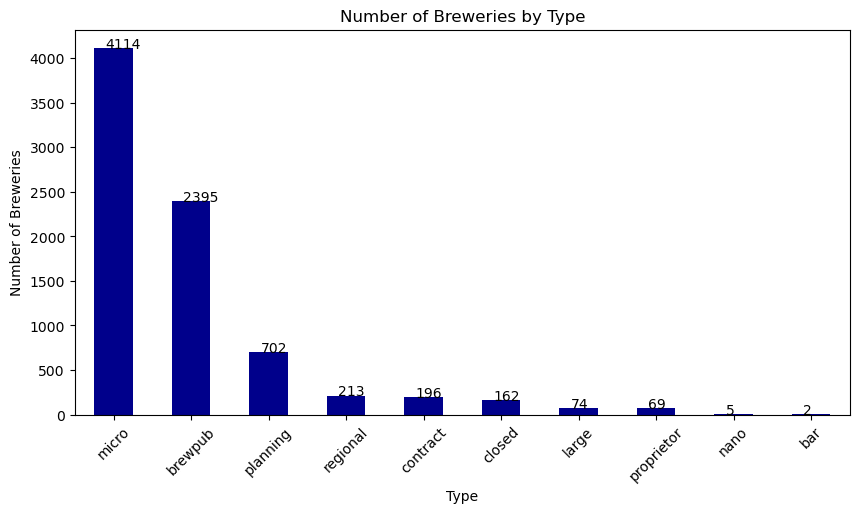

In [141]:
#Natalia's plot of breweries by type
#exclude from the plot closed and planning breweries
#data_count3 = brewery_last[brewery_last['brewery_type'] != 'planning']
#data_count3 = brewery_last[brewery_last['brewery_type'] != 'closed']

data_count3 = complete_breweries["brewery_type"].value_counts()
brewery_plot = data_count3.sort_values(ascending=False)

#plot breweries by type 
brewery_plot.plot(kind='bar', figsize=(10,5), color='darkblue', legend=False)

#add value counts above each bar
for i in range(len(brewery_plot)):
    plt.text(x=i-0.1 , y=brewery_plot[i]+0.5, s=brewery_plot[i], size=10)


plt.xticks(rotation=45)

plt.xlabel("Type")
plt.ylabel("Number of Breweries")
plt.title("Number of Breweries by Type")
plt.savefig("figs_graphs/all_breweries_by_type.png")

In [98]:
# Rajan's plot highlighting micorbrewery & pub locations across US 

# Bar graph brewries by state by type
#no_planning_closed_breweries = breweries_df.loc[(breweries_df["brewery_type"] != "planning") + (breweries_df["brewery_type"] != "closed")]
micro_pub_breweries = brewery_last.loc[(brewery_last["brewery_type"] == "pub") + (brewery_last["brewery_type"] == "micro")]
california_breweries = brewery_last.loc[brewery_last["State"] == "California"]

In [110]:
#Rajan's Map Plot of micro & pub brewery locations
map_plot_1 = micro_pub_breweries.hvplot.points(
    "longitude",
    "latitude",
    geo = True,
    tiles = "OSM",
    frame_width = 800,
    frame_height = 600,
    hover_cols = ["name", "brewery_type", "city"],   
)
map_plot_1

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [longitude,latitude]   (name,brewery_type)

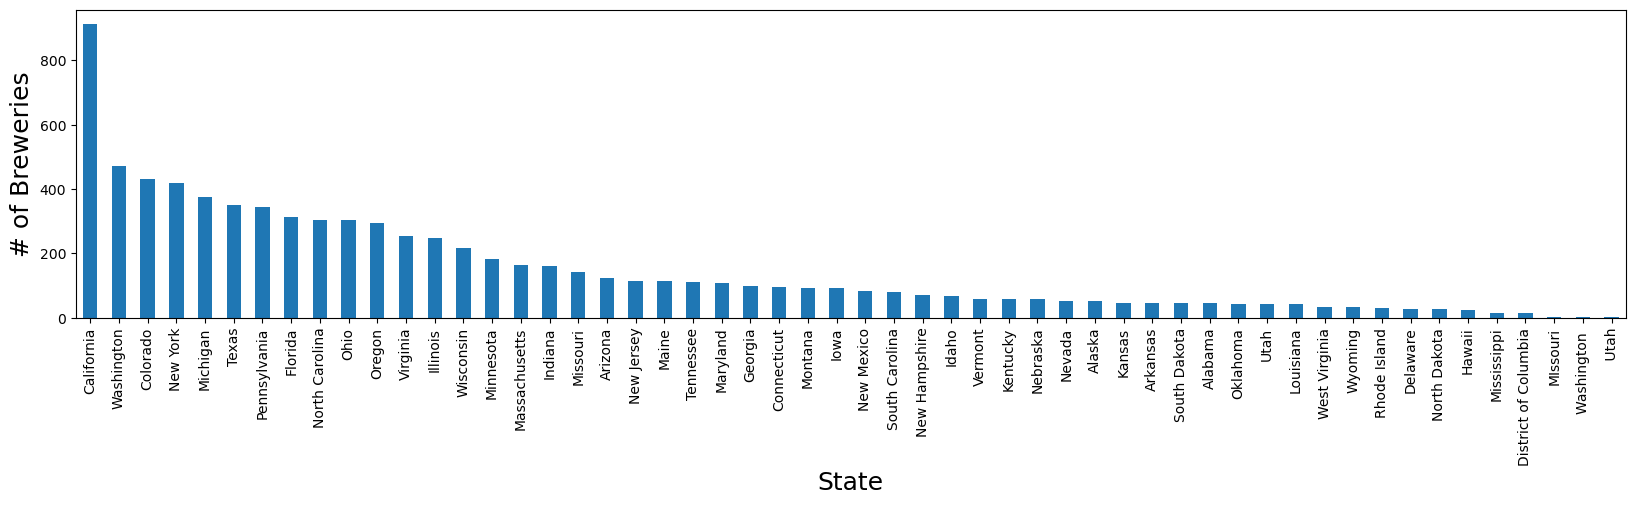

In [103]:
#Andrew's breweries across all types of brewereis per state

# Generate a bar plot showing total number of breweries by state 
brew_by_state = brewery_last.groupby(["state"])["brewery_type"].count()

brew_by_state = brew_by_state.sort_values(ascending=False)
brew_by_state_df = pd.DataFrame(brew_by_state)

# Display bar plot, label x and y, apply formatting 
brew_chart = brew_by_state_df.plot(kind="bar", figsize=(20,4), legend=False)
brew_chart.set_xlabel("State", fontsize=18)
brew_chart.set_ylabel("Number of Breweries", fontsize=18)
plt.title("Number of Breweries per State")

# Save an image of the chart and print it to the screen
plt.savefig("figs_graphs/breweries_per_state.png", bbox_inches="tight")
plt.show()
